# [GN_1]SentensePiece vs  Mecab vs OKT  형태소 분석기 비교

Nave_review 데이타 셋을 기반으로 SentensePiece vs Mecab vs OKT의 형태소 분석기별 성능 비교한다.

- 평가 공통 기준
    - Vacabulary size = 8000개 
    - Embedding Word vectors Dimension = 100
<br>
- SentensePiece에서는 이미 이전 프로젝트에서 작성했던 Model과 Vocab 파일을 Import해서 사용했다.
- Mecab과 OKT는 코드 상에서 Vacabulary를 구성하고 이를 Embedding에 사용했다. 

# 1. Data 준비

## 1.1 Data Load

In [1]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd

%matplotlib inline

In [2]:
train_data = pd.read_table('./data/ratings_train.txt')
test_data = pd.read_table('./data/ratings_test.txt')

len(train_data), len(test_data)

(150000, 50000)

## 1.2 Data 전처리

In [3]:
train_data.drop_duplicates(subset=['document'], inplace=True) # 중복제거
train_data = train_data.dropna(how = 'any')  # NA제거
train_data['document'] = train_data['document'].str.replace(r"[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9]"," ",regex=True) # 특수문자 제거 - Regex


test_data.drop_duplicates(subset=['document'], inplace=True) # 중복제거
test_data = test_data.dropna(how = 'any')  # NA제거
test_data['document'] = test_data['document'].str.replace(r"[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9]"," ",regex=True) # 특수문자 제거 - Regex

In [4]:
train_data.head()

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠 포스터보고 초딩영화줄 오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다 평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화 스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# 2.Tokenize 

## 2.1 SentencePiece Tokenizer 준비

In [5]:
import sentencepiece as spm

In [6]:
def sp_tokenize(sp_model, corpus,vocab_file):

    seq_list = []
    
    for sen in corpus:
        seq_list.append(sp_model.EncodeAsIds(sen))

    with open("./{}.vocab".format(vocab_file), 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    return seq_list, word_index, index_word

In [7]:
def spm_tokenizer(sp_model, train_data, test_data):
   s = spm.SentencePieceProcessor()
   s.Load('{}.model'.format(sp_model))
   s.SetEncodeExtraOptions('bos:eos')

   X_train, word_index, index_word = sp_tokenize(s, train_data['document'], sp_model)
   y_train =  np.array(list(train_data['label']))
   
   X_test, _ , _ = sp_tokenize(s,test_data['document'], sp_model )
   y_test =  np.array(list(test_data['label']))
   
   return X_train, y_train, X_test, y_test, word_index, index_word

## 2.2 Mecab, OKT  Tokenizer 준비


KoNLPy 계열인 Mecab과 OKT는 공통으로 사용할 model_tokenizer 를 구현해서 모델별로 호출한다. 

In [8]:
from konlpy.tag import Mecab
from konlpy.tag import Okt
import numpy as np
from collections import Counter

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras import regularizers
from keras.layers import Dropout

In [9]:
def model_tokenizer(model, train_data, test_data):
    X_train = []
    for sentence in train_data['document']:
        temp_X = model.morphs(sentence) # 토큰화
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = model.morphs(sentence) # 토큰화
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(8000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>','<UNUSED>'] + [key for key, _ in counter] 
    word_to_index = {word:index for index, word in enumerate(vocab)}
    index_word = {index:word for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index , index_word

# 3.LSTM 모델 훈련 

## 3.1 모델 준비

In [10]:
def model_training(model,X_train, y_train, X_val, y_val, epochs):
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience = 2
        )
    ]
    model.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])
                    
    epochs=epochs  

    history = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        batch_size=512,
                        validation_data=(X_val, y_val),
                        callbacks = callbacks,
                        verbose=1)
    return history

In [20]:
def LSTM_training(X_train_data, y_train_data, X_test, y_test):
    vocab_size_ = 8000
    word_vector_dim_ = 100    
    maxlen = 30

    X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train_data,
                                                        value=0,
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

    X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                        value=0,
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

    partial_X_train, x_val, partial_y_train, y_val = train_test_split(X_train, y_train_data, test_size=0.2)


    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(vocab_size_, 
                                        word_vector_dim_, 
                                        input_shape=(None,)
                                        ))
    model.add(Bidirectional(tf.keras.layers.LSTM(32)))  
    model.add(Dropout(0.2))  
    model.add(tf.keras.layers.Dense(8, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  
    history = model_training(model,partial_X_train, partial_y_train, x_val, y_val,10)
    results = model.evaluate(X_test,  y_test, verbose=2)
    print(results)
    return history, results

## 3.2 모델 훈련

### 3.2.1 SentencePiece  훈련

In [13]:
# 1.sp  vocab 8000, word_dim 100
X_train, y_train, X_test, y_test, _, _ = spm_tokenizer('naver_review_spm_8000_unigram',train_data,test_data)
history_sp, results_sp = LSTM_training(X_train, y_train, X_test, y_test)


Epoch 1/10
229/229 [==============================] - 7s 19ms/step - loss: 0.4465 - accuracy: 0.7882 - val_loss: 0.3577 - val_accuracy: 0.8452
Epoch 2/10
229/229 [==============================] - 3s 14ms/step - loss: 0.3319 - accuracy: 0.8568 - val_loss: 0.3470 - val_accuracy: 0.8502
Epoch 3/10
229/229 [==============================] - 3s 13ms/step - loss: 0.3082 - accuracy: 0.8649 - val_loss: 0.3465 - val_accuracy: 0.8494
Epoch 4/10
229/229 [==============================] - 3s 15ms/step - loss: 0.2871 - accuracy: 0.8721 - val_loss: 0.3505 - val_accuracy: 0.8509
Epoch 5/10
229/229 [==============================] - 3s 15ms/step - loss: 0.2664 - accuracy: 0.8806 - val_loss: 0.3677 - val_accuracy: 0.8494
Epoch 6/10
229/229 [==============================] - 3s 13ms/step - loss: 0.2473 - accuracy: 0.8887 - val_loss: 0.3707 - val_accuracy: 0.8467
1537/1537 - 7s - loss: 0.3748 - accuracy: 0.8421 - 7s/epoch - 5ms/step
[0.3748425841331482, 0.8420774340629578]


### 3.2.2 Mecab  훈련

In [14]:
# 2 mecab 
mecab = Mecab('C:\mecab\mecab-ko-dic')
X_train, y_train, X_test, y_test, _, _ = model_tokenizer(mecab, train_data, test_data)
history_mecab, results_mecab = LSTM_training(X_train, y_train, X_test, y_test)


Epoch 1/10
229/229 [==============================] - 7s 18ms/step - loss: 0.4439 - accuracy: 0.7914 - val_loss: 0.3582 - val_accuracy: 0.8412
Epoch 2/10
229/229 [==============================] - 3s 14ms/step - loss: 0.3327 - accuracy: 0.8552 - val_loss: 0.3486 - val_accuracy: 0.8438
Epoch 3/10
229/229 [==============================] - 3s 13ms/step - loss: 0.3068 - accuracy: 0.8656 - val_loss: 0.3502 - val_accuracy: 0.8458
Epoch 4/10
229/229 [==============================] - 3s 13ms/step - loss: 0.2836 - accuracy: 0.8761 - val_loss: 0.3549 - val_accuracy: 0.8444
Epoch 5/10
229/229 [==============================] - 3s 13ms/step - loss: 0.2633 - accuracy: 0.8850 - val_loss: 0.3656 - val_accuracy: 0.8448
1537/1537 - 7s - loss: 0.3669 - accuracy: 0.8443 - 7s/epoch - 5ms/step
[0.3668847680091858, 0.8443151712417603]


### 3.2.3 OKT  훈련

In [15]:
# OKT 
okt = Okt()
X_train, y_train, X_test, y_test, word_index, index_word = model_tokenizer(okt, train_data, test_data)
history_okt, results_okt = LSTM_training(X_train, y_train, X_test, y_test)



Epoch 1/10
229/229 [==============================] - 6s 18ms/step - loss: 0.4520 - accuracy: 0.7853 - val_loss: 0.3714 - val_accuracy: 0.8333
Epoch 2/10
229/229 [==============================] - 3s 13ms/step - loss: 0.3347 - accuracy: 0.8533 - val_loss: 0.3580 - val_accuracy: 0.8387
Epoch 3/10
229/229 [==============================] - 3s 14ms/step - loss: 0.3096 - accuracy: 0.8633 - val_loss: 0.3588 - val_accuracy: 0.8384
Epoch 4/10
229/229 [==============================] - 3s 14ms/step - loss: 0.2860 - accuracy: 0.8722 - val_loss: 0.3721 - val_accuracy: 0.8369
1537/1537 - 7s - loss: 0.3753 - accuracy: 0.8363 - 7s/epoch - 5ms/step
[0.3752853274345398, 0.8363000154495239]


# 4.Visualization

## 4.1 Training Visualization

In [76]:
def visualize_train(train_history, param):
    
    fig, ax = plt.subplots(1,2,figsize = (10,3))
    # fig.suptitle('100 vs 200  '+ val, fontsize=16)
    
    plt.subplot(1,2,1)
    plt.plot(train_history.history['accuracy'])
    plt.plot(train_history.history['val_accuracy'])
    plt.title('{}_accuracy'.format(param))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    
    plt.subplot(1,2,2)
    plt.plot(train_history.history['loss'])
    plt.plot(train_history.history['val_loss'])
    plt.title('{}_loss'.format(param))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

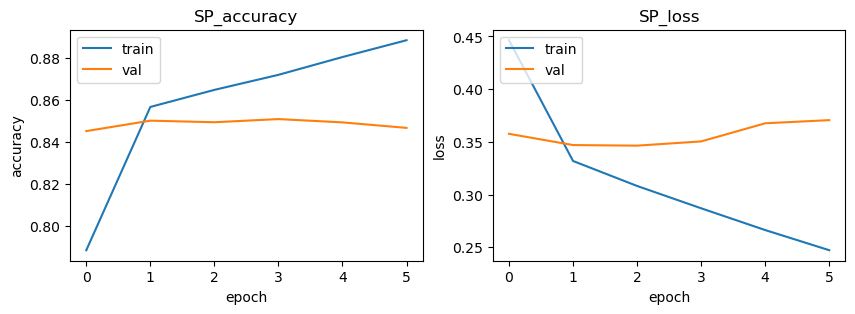

In [77]:
visualize_train(history_sp, param='SP')

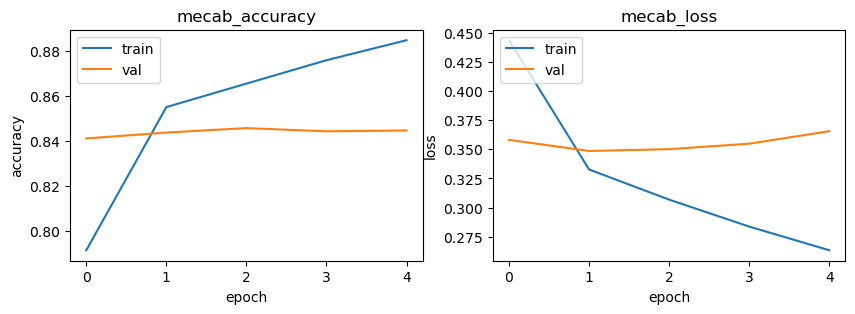

In [78]:
visualize_train(history_mecab, param='mecab')

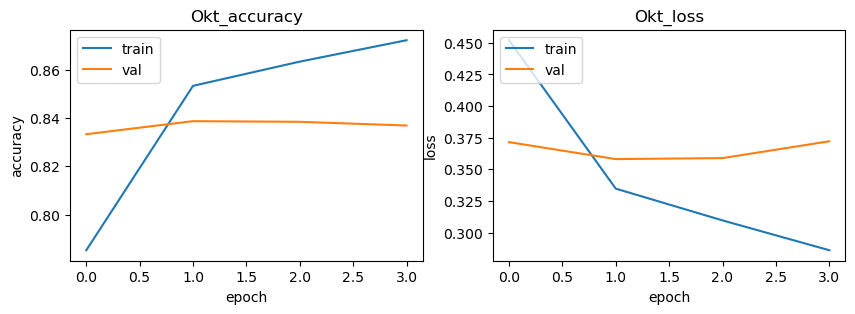

In [79]:
visualize_train(history_okt, param='Okt')

📝 SP, Mecab, OKT 세 모델 모두 Epoch 2 부근에서 성능이 거의 나아지지 않고 과적합 되려는 모습을 보인다. 

## 4.2 모델별 Train과정 visualization

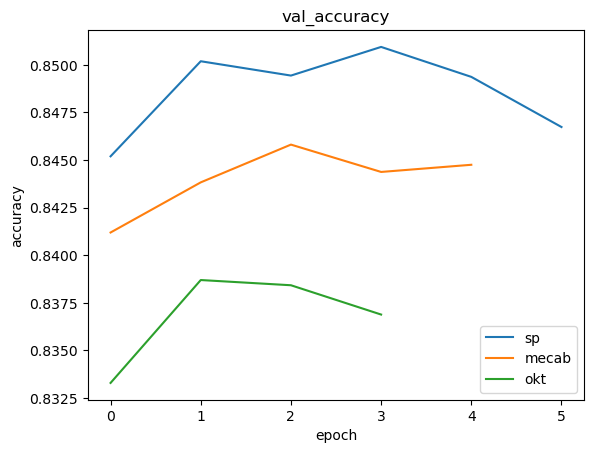

In [17]:
    val = 'val_accuracy'
    
    plt.plot(history_sp.history[val])
    plt.plot(history_mecab.history[val])
    plt.plot(history_okt.history[val])
    plt.title(val)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['sp', 'mecab', 'okt'], loc='lower right')
    plt.show()


📝 SP, Mecab, OKT 세모델에 대한 Validation set의 Accuracy를 보면 SP가 epoch 초기부터 근소한 차이로 높다.

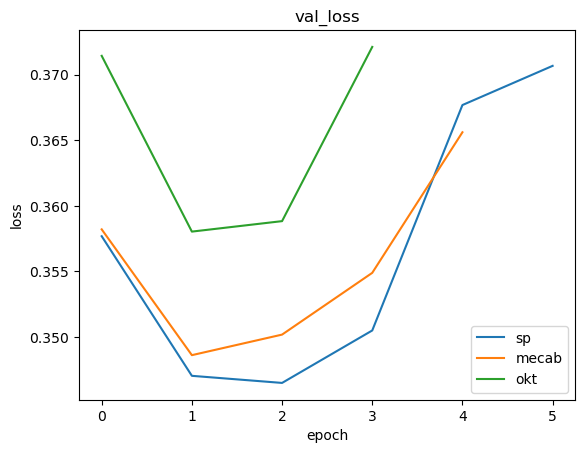

In [18]:
    val = 'val_loss'
    
    plt.plot(history_sp.history[val])
    plt.plot(history_mecab.history[val])
    plt.plot(history_okt.history[val])
    plt.title(val)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['sp', 'mecab', 'okt'], loc='lower right')
    plt.show()

📝 SP, Mecab, OKT 세모델에 대한 Validation set의 Loss 보면 SP가 epoch 초기부터 근소한 차이로 높다.

## 4.3 Test Set 평가 결과 Visualization

Test Data Set을 통해 각 모델별 평가 결과 Loss와 Accuracy를 비교 한다.

In [22]:

data = {'col': ['sp','mecab','okt'],'loss': [results_sp[0], results_mecab[0], results_okt[0]],
        'accuracy': [results_sp[1], results_mecab[1], results_okt[1]]}
results_df = pd.DataFrame(data)
results_df

,col,loss,accuracy
0,sp,0.374843,0.842077
1,mecab,0.366885,0.844315
2,okt,0.375285,0.836300


In [101]:
def visualize_by_model(val, ylim_low, ylim_high):
    fig = plt.figure() 
    ax1 = fig.add_subplot(1,1,1) 
    colors = ['steelblue', 'orange', 'forestgreen']

    bars = ax1.bar(results_df['col'],results_df[val], color= colors)

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x()+ 0.25, yval + 0.0002, round(yval,3), fontsize=10)
        
    plt.xlabel('Tokenizer Model')
    plt.ylabel(val)
    plt.ylim(ylim_low,ylim_high)
    plt.title("Tokenizer Model "+val)
    plt.show()


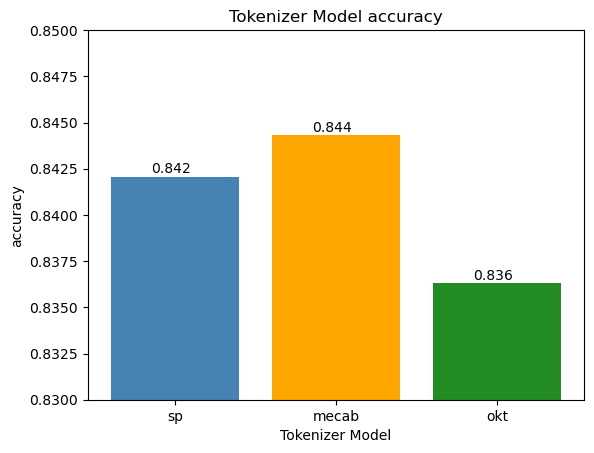

In [103]:
visualize_by_model('accuracy',0.83,0.85)

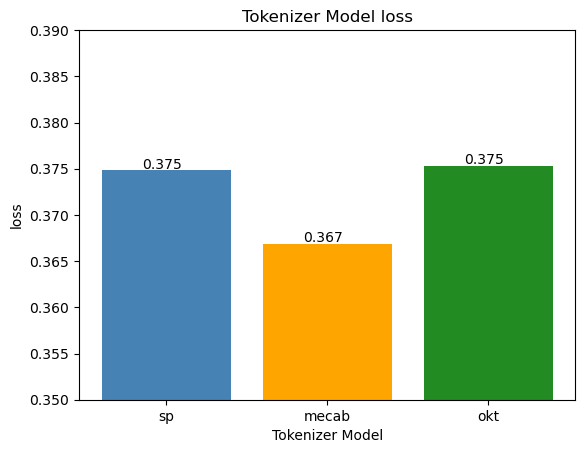

In [106]:
visualize_by_model('loss',0.35,0.39)

📝 Test set으로 평가한 결과 Accuracy와 Loss에서  __`Mecab`__ 이 다른 두 모델에 비해 근소한 차이로 좋은 성능을 보였다.    
본 평가는 Vacabulary Size 8000개와 Word Vector Dim 100으로 Epochs 10이내에서 EarlyStopping을 설정하여 진행 되었다. 

# 5.회고

- 각 형태소 분석기별로 Vacabulary를 구성하고 Vectorize를 진행하며 처음으로 OKT를 사용해 봤다. 
- Mecab과  OKT 이 모두 KoNLPy 패키지라서 사용 방법이 비슷했다. 그래서 Tokenizer를 구성 할 때도 공통함수(model_tokenizer)를 만들어 손쉽게 사용할 수 있었다. 
- 각 모델별로 성능 평가를 했지만, 의미있을 만큼 뚜렷한 차이를 보이지는 않았다. Vocabulary size나 word vector Dim을 변경하면서 좀 더 시도해 의미있는 차이를 더 보고 싶다. 
- 모델을 평가하기 위해 평가 기준을 만들고, 그것을 어떤 기준으로 Visualization해야 효과적이고 의미있게 보일지 고민했다. 
- LSTM 모델 Training 과정에서 기록하는 validation accuracy, validation loss 의 그래프를 보면서 보면서 sp 모델이 그래프 흐름상으로는 더 성능이 좋아보이는데,<img src='https://user-images.githubusercontent.com/95423215/240846080-4859ddbd-47f9-422c-babd-51ca78048f6a.png' width='80%' height='80%'>

 - Test Set의 Accuracy, loss를 보면 Mecab이 근소한 차이로 좋아서 어느 것을 결론적으로 더 나은 모델이라 할 수 있을지 팀원들과 의견을 공유했다.<img src='https://user-images.githubusercontent.com/95423215/240847123-524147fc-0d44-4366-a4c5-4b892043536d.png' width='80%' height='80%'>  
- 결론 모델의 범용성을 확보하기 위해서 처음본 데이타에서 받은 평가를 더 신뢰할 수 있다는 의견에 나도 동의 해서 Test 데이타에서 평가결과로 나온 `Mecab`을 더 나은 모델로 선정했다. 
- 성능 평가의 여러 기준과 지표들에 대해서 어떤 것을 의미있게 생각해야 하는지 고민하고 표현해 보는 의미있는 시간이었다. 
 
